In [16]:
# Step 0: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve,auc
import matplotlib.pyplot as plt

In [17]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

# Combine into one DataFrame for easier processing
df = pd.concat([X, y], axis=1) 
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [18]:
data=df.dropna()

In [19]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [20]:
categorical_cols = ['cp', 'restecg', 'slope', 'thal']
df_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [21]:
from sklearn.preprocessing import MinMaxScaler

# columns need scalling
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

df_scaled = df_encoded.copy()

scaler = MinMaxScaler()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

In [22]:
df_scaled.head(10)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,num,cp_2,cp_3,cp_4,restecg_1,restecg_2,slope_2,slope_3,thal_6.0,thal_7.0
0,0.708333,1,0.481132,0.244292,1,0.603053,0,0.370968,0.000000,0,False,False,False,False,True,False,True,True,False
1,0.791667,1,0.622642,0.365297,0,0.282443,1,0.241935,1.000000,2,False,False,True,False,True,True,False,False,False
2,0.791667,1,0.245283,0.235160,0,0.442748,1,0.419355,0.666667,1,False,False,True,False,True,True,False,False,True
3,0.166667,1,0.339623,0.283105,0,0.885496,0,0.564516,0.000000,0,False,True,False,False,False,False,True,False,False
4,0.250000,0,0.339623,0.178082,0,0.770992,0,0.225806,0.000000,0,True,False,False,False,True,False,False,False,False
5,0.562500,1,0.245283,0.251142,0,0.816794,0,0.129032,0.000000,0,True,False,False,False,False,False,False,False,False
6,0.687500,0,0.433962,0.324201,0,0.679389,0,0.580645,0.666667,3,False,False,True,False,True,False,True,False,False
7,0.583333,0,0.245283,0.520548,0,0.702290,1,0.096774,0.000000,0,False,False,True,False,False,False,False,False,False
8,0.708333,1,0.339623,0.292237,0,0.580153,0,0.225806,0.333333,2,False,False,True,False,True,True,False,False,True
9,0.500000,1,0.433962,0.175799,1,0.641221,1,0.500000,0.000000,1,False,False,True,False,True,False,True,False,True


In [23]:
df_scaled.isnull().sum()

age          0
sex          0
trestbps     0
chol         0
fbs          0
thalach      0
exang        0
oldpeak      0
ca           0
num          0
cp_2         0
cp_3         0
cp_4         0
restecg_1    0
restecg_2    0
slope_2      0
slope_3      0
thal_6.0     0
thal_7.0     0
dtype: int64

In [24]:
# Convert multi-class target into binary (0 = no disease, 1 = disease)
df_scaled["num_binary"] = df_scaled["num"].apply(lambda x: 1 if x > 0 else 0)

# Use this as target
y = df_scaled["num_binary"]
X = df_scaled.drop(["num", "num_binary"], axis=1)

In [25]:
# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: num_binary, dtype: int64

In [27]:
# ===== 2.7 Model Export & Deployment =====
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [28]:
#define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(probability=True, random_state=42)
}

✅ Logistic Regression pipeline saved as Logistic_Regression_pipeline.pkl
✅ Decision Tree pipeline saved as Decision_Tree_pipeline.pkl
✅ Random Forest pipeline saved as Random_Forest_pipeline.pkl
✅ SVM pipeline saved as SVM_pipeline.pkl


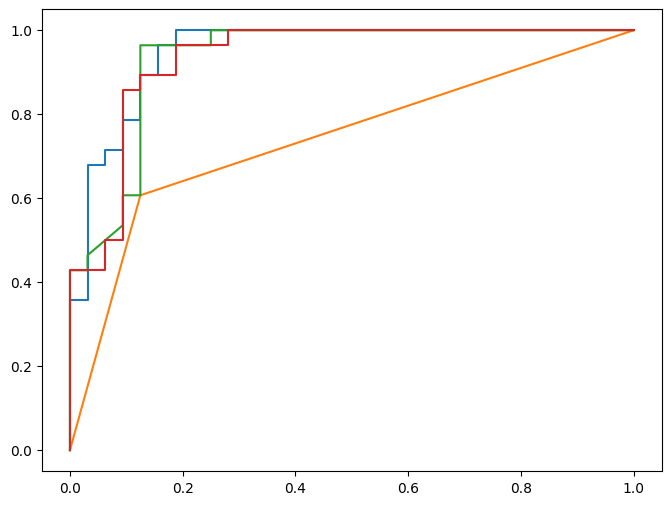

In [29]:
results = {}

plt.figure(figsize=(8,6))

for name, model in models.items():
    # Create pipeline (preprocessing + model)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),   # preprocessing
        ("classifier", model)           # model
    ])
    
    # Train pipeline
    pipeline.fit(X_train, y_train)
    
    # Save pipeline to .pkl file
    filename = f"{name.replace(' ', '_')}_pipeline.pkl"
    joblib.dump(pipeline, filename)
    print(f"✅ {name} pipeline saved as {filename}")
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob)

    # Save results
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "AUC": auc_score
    }

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")


C:\Users\Delta\AppData\Local\Temp\ipykernel_5116\2221875261.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


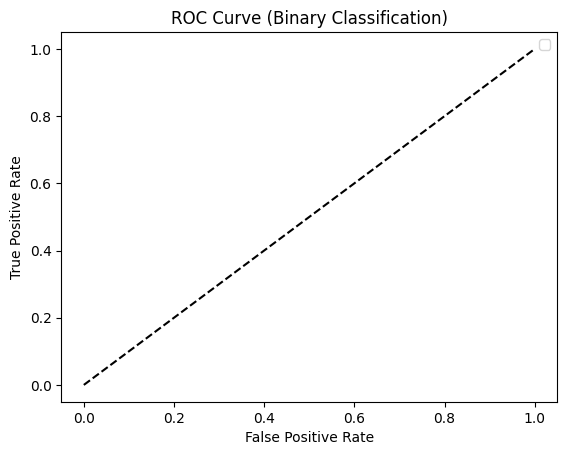


=== Final Results ===
                     Accuracy  Precision    Recall  F1-score       AUC
Logistic Regression  0.833333   0.846154  0.785714  0.814815  0.949777
Decision Tree        0.750000   0.809524  0.607143  0.693878  0.741071
Random Forest        0.816667   0.840000  0.750000  0.792453  0.934152
SVM                  0.850000   0.880000  0.785714  0.830189  0.934152


In [30]:
# Final ROC Curve
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary Classification)")
plt.legend()
plt.show()

# Print results table
import pandas as pd
results_df = pd.DataFrame(results).T
print("\n=== Final Results ===")
print(results_df)